In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import pandas as pd
import plotly.plotly as py

In [2]:
data_frame = pd.read_csv("../dummy2.csv", header=None)

count_data = data_frame[1].as_matrix()

n_count_data = len(count_data)

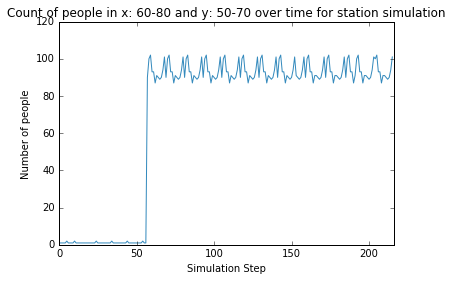

In [3]:
plt.plot(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Simulation Step")
plt.ylabel("Number of people")
plt.title("Count of people in x: 60-80 and y: 50-70 over time for station simulation")
plt.xlim(0, n_count_data)
plt.show()

In [4]:
# pymc
# set hyper-parameter as inverse of data mean
alpha = 1.0 / count_data.mean()


# same prior for both lambdas
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)

# Or uniform throughout
tau_1 = pm.DiscreteUniform("tau_1", lower=0, upper=n_count_data)


@pm.deterministic
def lambda_(tau_1=tau_1, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_count_data)
    out[:tau_1] = lambda_1  # lambda before tau is lambda1
    out[tau_1:] = lambda_2
    return out

observation = pm.Poisson("obs", lambda_, value=count_data, observed=True)
model = pm.Model([observation, lambda_1, lambda_2, tau_1])

# Markov Model Monte Carlo
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000, 1)

lambda_1_samples = mcmc.trace("lambda_1")[:]
lambda_2_samples = mcmc.trace("lambda_2")[:]
tau_1_samples = mcmc.trace("tau_1")[:]

 [-----------------100%-----------------] 40000 of 40000 complete in 36.6 sec

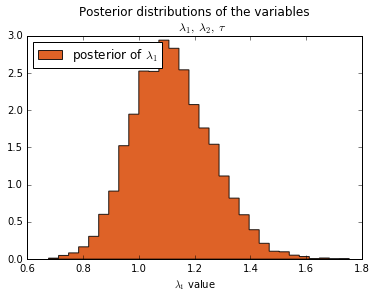

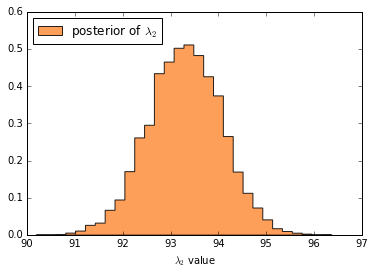

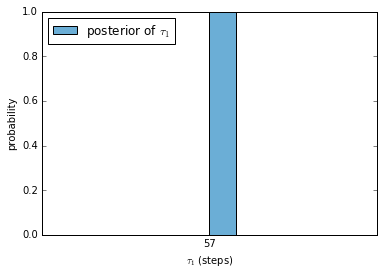

In [5]:
# Histogram of samples

# LAMBDA 1
plt.hist(lambda_1_samples, histtype="stepfilled", bins=30, alpha=0.85,
    label = "posterior of $\lambda_1$", color="#D94701", normed=True)
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.legend(loc="upper left")
#plt.xlim([0, n_count_data])
plt.xlabel("$\lambda_1$ value")
plt.show()

#LAMBDA 2
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#FD8D3C", normed=True)
plt.legend(loc="upper left")
#plt.xlim([0, n_count_data])
plt.xlabel("$\lambda_2$ value")
plt.show()


def hist_calcs(samples):
    #samples = tau_2_samples
    vals = sorted(list(set(samples)))

    counts = np.zeros(len(vals))
    for num in samples:
        counts[vals.index(num)] += 1
        
    percent = counts / float(samples.shape[0])
    
    return(vals, percent)

# TAU 1
vals, percentages = hist_calcs(tau_1_samples)
plt.bar(vals, percentages, label=r"posterior of $\tau_1$", color="#6BAED6")
plt.xticks(vals[::2])
plt.legend(loc="upper left")
plt.xlabel(r"$\tau_1$ (steps)")
plt.ylabel("probability");
mode = hist_calcs(tau_1_samples)[0][0]
plt.xlim(mode - 5, mode + 5)
plt.show()



In [6]:
import scipy.stats as st
print(st.mode(tau_1_samples))
print(st.mode(lambda_1_samples))
print(st.mode(lambda_2_samples))

ModeResult(mode=array([57]), count=array([30000]))
ModeResult(mode=array([1.09192722]), count=array([44]))
ModeResult(mode=array([93.96573317]), count=array([50]))
